# Modeling Baseline

## 0. Data load

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/기상청/데이터')

In [ ]:
#!pip install shap

In [ ]:
import numpy as np
import pandas as pd
import datetime
from datetime import timedelta
from tqdm.notebook import tqdm
tqdm.pandas()

import random
from functools import reduce

import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
%matplotlib inline

rc('font', family='MalgunGothic')
plt.rcParams['axes.unicode_minus'] = False

import shap
import xgboost as xgb
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor 
from sklearn.ensemble import GradientBoostingRegressor

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [ ]:
data_weather = pd.read_csv('data_with_weather.csv', encoding='CP949')
appliance = pd.read_csv('app_tsclustering2.csv', encoding='cp949')

In [ ]:
data_weather.head(2)

date sex  age big_cat  ...       PM25     hm_max  sum_ss_hr       max_pa
0  2018-01-01   F   20      식품  ...  21.477208  61.923313  52.276365  1020.592385
1  2018-01-01   F   30      식품  ...  21.477208  61.923313  52.276365  1020.592385

[2 rows x 18 columns]

In [ ]:
appliance.head(2)

sm_cat  01-01 00:00:00  ...  12-31 00:00:00  cluster
0    가스온수기       -0.574834  ...       -0.574834        2
1  가열식 가습기        2.097915  ...        0.499419        0

[2 rows x 367 columns]

## 1. Data for Modeling

### 1-1. Cluster

In [ ]:
data_weather['date'] = pd.to_datetime(data_weather['date'], format='%Y-%m-%d')

In [ ]:
def cluster_buy_df(c) : 
    clusterdf = appliance[appliance["cluster"] == c]
    df = data_weather[data_weather.sm_cat.isin(list(clusterdf["sm_cat"]))] 
    df = df.groupby(['date','sm_cat']).mean('qty').reset_index()
    return df

In [ ]:
df_0 = cluster_buy_df(0)
df_1 = cluster_buy_df(1)
df_2 = cluster_buy_df(2)

In [ ]:
df_0.head(2)

date   sm_cat   age   qty  ...       PM25     hm_max  sum_ss_hr       max_pa
0 2018-01-01  가열식 가습기  30.0  1.75  ...  21.477208  61.923313  52.276365  1020.592385
1 2018-01-01      돈풍기  35.0  1.00  ...  21.477208  61.923313  52.276365  1020.592385

[2 rows x 16 columns]

### 1-2. Train Test Split

In [ ]:
def sampling(data):
    # 랜덤으로 요일 선택
    sample_day = []; sample_idx = []
    count = 730//7 
    day_list = day_list = [1,2,3,4,5,6,7]
    sample_list = [random.choice(day_list) for i in range(count)]

    # 랜덤으로 선택된 요일의 날짜
    start = datetime.datetime(2018, 1, 1)
    for days in sample_list:
        sample_day.append(start + datetime.timedelta(days = days))
        start = start + datetime.timedelta(weeks = 1)

    # 샘플링
    for date in sample_day:
        sample_idx.extend(data[data['date']==date].index)
        
    all_idx = data.index.tolist()
    train_idx = list(set(all_idx) - set(sample_idx))
    return data.iloc[train_idx].reset_index(drop=True), data.iloc[sample_idx].reset_index(drop=True)

In [ ]:
train_0, test_0 = sampling(df_0)
train_1, test_1 = sampling(df_1)
train_2, test_2 = sampling(df_2)

In [ ]:
print(train_0.shape)
print(test_0.shape)
print(train_1.shape)
print(test_1.shape)
print(train_2.shape)
print(test_2.shape)

(8676, 16)
(655, 16)
(10072, 16)
(777, 16)
(3025, 16)
(227, 16)


In [ ]:
# 매주 한 요일씩 추출된 것 확인
print(len(test_0['date'].unique()))
print(len(test_1['date'].unique()))
print(len(test_2['date'].unique()))

52
52
52


### 1-3. Standardization

In [ ]:
train_num_0 = train_0.iloc[:,2:]
test_num_0 = test_0.iloc[:,2:]
train_num_1 = train_1.iloc[:,2:]
test_num_1 = test_1.iloc[:,2:]
train_num_2 = train_2.iloc[:,2:]
test_num_2 = test_2.iloc[:,2:]

In [ ]:
std_scaler = StandardScaler()
train_std_0 = std_scaler.fit_transform(train_num_0)
test_std_0 = std_scaler.transform(test_num_0)
train_std_1 = std_scaler.fit_transform(train_num_1)
test_std_1 = std_scaler.transform(test_num_1)
train_std_2 = std_scaler.fit_transform(train_num_2)
test_std_2 = std_scaler.transform(test_num_2)

### 1-4. Variable

In [ ]:
train_Y_0, train_X_0 = train_num_0[['qty']], train_num_0[train_num_0.columns.difference(['qty','age'])]
test_Y_0, test_X_0 = test_num_0[['qty']], test_num_0[test_num_0.columns.difference(['qty','age'])]
train_Y_1, train_X_1 = train_num_1[['qty']], train_num_1[train_num_1.columns.difference(['qty','age'])]
test_Y_1, test_X_1 = test_num_1[['qty']], test_num_1[test_num_1.columns.difference(['qty','age'])]
train_Y_2, train_X_2 = train_num_2[['qty']], train_num_2[train_num_2.columns.difference(['qty','age'])]
test_Y_2, test_X_2 = test_num_2[['qty']], test_num_2[test_num_2.columns.difference(['qty','age'])]

## 2. Modeling

### 2-1. XGBoost

In [ ]:
xgb_model = xgb.XGBRegressor(learning_rate=0.1, max_depth=5, n_estimators=100) 
xgb_model.fit(train_X_0, train_Y_0)
pred_Y_0 = xgb_model.predict(test_X_0)
print(mean_squared_error(test_Y_0, pred_Y_0))

[06:58:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
47.64685242405675


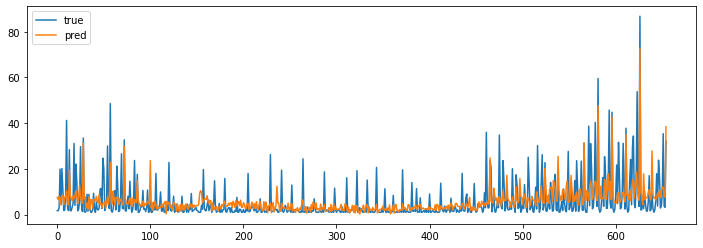

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(test_Y_0, label='true')
plt.plot(pred_Y_0, label='pred')
plt.legend(loc = 'best')
plt.show()

In [ ]:
pd.DataFrame({
    'col' : train_X_0.columns, 'feature importance' : xgb_model.feature_importances_
}).sort_values('feature importance', ascending=False)

col  feature importance
7      max_ta            0.188072
2      avg_ta            0.159651
4         cnt            0.134673
6      max_pa            0.126121
1        PM25            0.079395
8      min_ta            0.076365
0        PM10            0.048739
5      hm_max            0.046003
11  sum_ss_hr            0.040798
3      avg_ws            0.038592
9      rn_day            0.034065
10     rn_hr1            0.027528

In [ ]:
xgb_model.fit(train_X_1, train_Y_1)
pred_Y_1 = xgb_model.predict(test_X_1)
print(mean_squared_error(test_Y_1, pred_Y_1))

[06:58:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
48.09385883139615


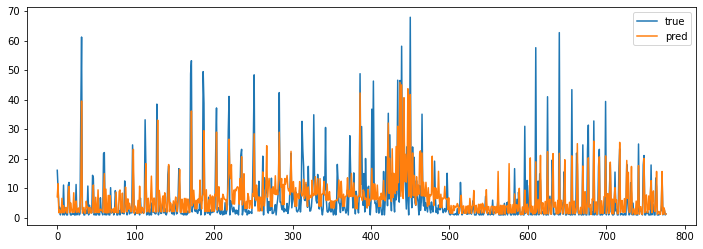

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(test_Y_1, label='true')
plt.plot(pred_Y_1, label='pred')
plt.legend(loc = 'best')
plt.show()

In [ ]:
pd.DataFrame({
    'col' : train_X_0.columns, 'feature importance' : xgb_model.feature_importances_
}).sort_values('feature importance', ascending=False)

col  feature importance
4         cnt            0.278722
8      min_ta            0.120401
10     rn_hr1            0.093528
5      hm_max            0.082348
7      max_ta            0.075249
6      max_pa            0.071734
1        PM25            0.069303
0        PM10            0.051330
2      avg_ta            0.047954
9      rn_day            0.044734
11  sum_ss_hr            0.034220
3      avg_ws            0.030476

In [ ]:
xgb_model.fit(train_X_2, train_Y_2)
pred_Y_2 = xgb_model.predict(test_X_2)
print(mean_squared_error(test_Y_2, pred_Y_2))

[06:59:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
10.88505509679522


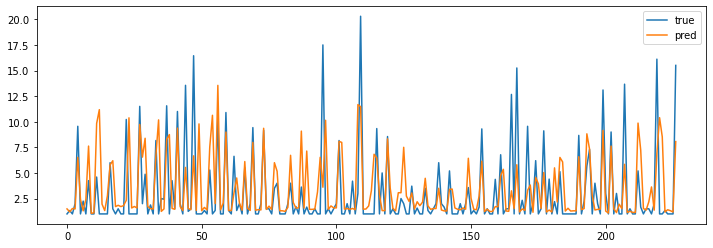

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(test_Y_2, label='true')
plt.plot(pred_Y_2, label='pred')
plt.legend(loc = 'best')
plt.show()

In [ ]:
pd.DataFrame({
    'col' : train_X_0.columns, 'feature importance' : xgb_model.feature_importances_
}).sort_values('feature importance', ascending=False)

col  feature importance
4         cnt            0.191406
8      min_ta            0.111070
7      max_ta            0.101049
1        PM25            0.095833
6      max_pa            0.092038
5      hm_max            0.073840
2      avg_ta            0.073025
11  sum_ss_hr            0.068444
3      avg_ws            0.055821
0        PM10            0.055718
10     rn_hr1            0.041736
9      rn_day            0.040022

In [ ]:
shap.initjs()
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(train_X_2)

findfont: Font family ['MalgunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['MalgunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['MalgunGothic'] not found. Falling back to DejaVu Sans.


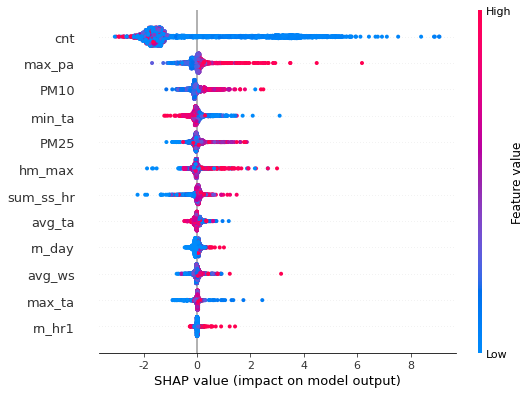

In [ ]:
shap.summary_plot(shap_values, train_X_2)

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], train_X_2.iloc[0,:])

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, train_X_2)

shap.plots.force is slow for many thousands of rows, try subsampling your data.


### 2-2. RandomForest

In [ ]:
rf_model = RandomForestRegressor() 
rf_model.fit(train_X_0, train_Y_0)
pred_Y_0 = rf_model.predict(test_X_0)
print(mean_squared_error(test_Y_0, pred_Y_0))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


49.512442792417374


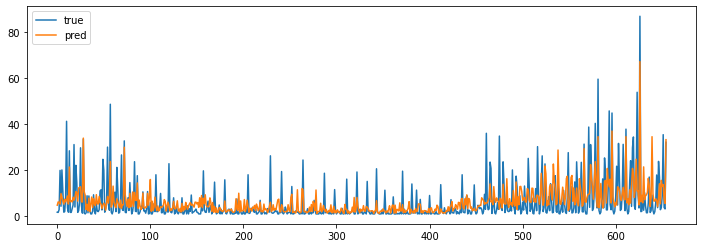

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(test_Y_0, label='true')
plt.plot(pred_Y_0, label='pred')
plt.legend(loc = 'best')
plt.show()

In [ ]:
pd.DataFrame({
    'col' : train_X_0.columns, 'feature importance' : rf_model.feature_importances_
}).sort_values('feature importance', ascending=False)

col  feature importance
4         cnt            0.508259
6      max_pa            0.088658
2      avg_ta            0.063680
7      max_ta            0.062330
0        PM10            0.046243
1        PM25            0.044591
3      avg_ws            0.043982
8      min_ta            0.041766
5      hm_max            0.038521
11  sum_ss_hr            0.034238
10     rn_hr1            0.014718
9      rn_day            0.013013

In [ ]:
rf_model.fit(train_X_1, train_Y_1)
pred_Y_1 = rf_model.predict(test_X_1)
print(mean_squared_error(test_Y_1, pred_Y_1))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


47.83418347112002


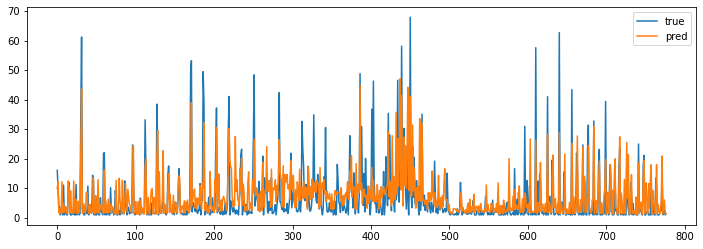

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(test_Y_1, label='true')
plt.plot(pred_Y_1, label='pred')
plt.legend(loc = 'best')
plt.show()

In [ ]:
pd.DataFrame({
    'col' : train_X_0.columns, 'feature importance' : rf_model.feature_importances_
}).sort_values('feature importance', ascending=False)

col  feature importance
4         cnt            0.666111
1        PM25            0.043279
0        PM10            0.040170
6      max_pa            0.039839
8      min_ta            0.036747
11  sum_ss_hr            0.032983
2      avg_ta            0.031164
3      avg_ws            0.030543
5      hm_max            0.028474
7      max_ta            0.026908
9      rn_day            0.012982
10     rn_hr1            0.010800

In [ ]:
rf_model.fit(train_X_2, train_Y_2)
pred_Y_2 = rf_model.predict(test_X_2)
print(mean_squared_error(test_Y_2, pred_Y_2))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


11.17878364342591


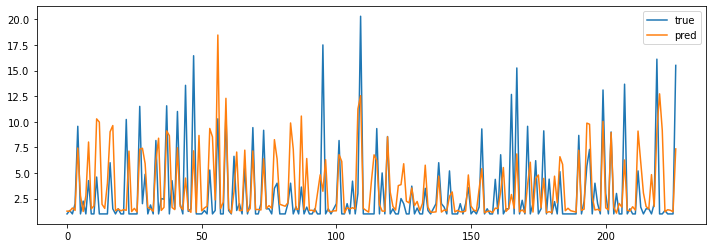

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(test_Y_2, label='true')
plt.plot(pred_Y_2, label='pred')
plt.legend(loc = 'best')
plt.show()

In [ ]:
pd.DataFrame({
    'col' : train_X_0.columns, 'feature importance' : rf_model.feature_importances_
}).sort_values('feature importance', ascending=False)

col  feature importance
4         cnt            0.480929
6      max_pa            0.089856
1        PM25            0.057483
5      hm_max            0.055541
3      avg_ws            0.054582
8      min_ta            0.053370
0        PM10            0.052902
11  sum_ss_hr            0.048383
2      avg_ta            0.036374
7      max_ta            0.034154
9      rn_day            0.018504
10     rn_hr1            0.017921

### 2-3. LGBM

In [ ]:
lgb_model = lgb.LGBMRegressor() 
lgb_model.fit(train_X_0, train_Y_0)
pred_Y_0 = lgb_model.predict(test_X_0)
print(mean_squared_error(test_Y_0, pred_Y_0))

47.37443570240654


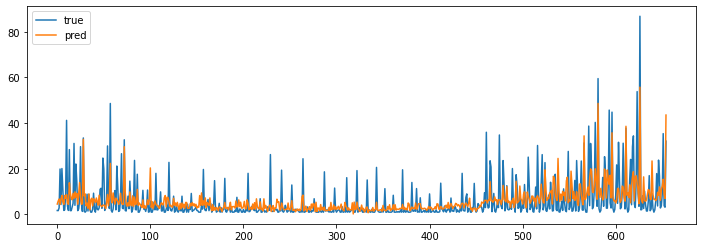

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(test_Y_0, label='true')
plt.plot(pred_Y_0, label='pred')
plt.legend(loc = 'best')
plt.show()

In [ ]:
pd.DataFrame({
    'col' : train_X_0.columns, 'feature importance' : lgb_model.feature_importances_
}).sort_values('feature importance', ascending=False)

col  feature importance
4         cnt                1171
6      max_pa                 323
0        PM10                 218
5      hm_max                 187
1        PM25                 186
2      avg_ta                 171
3      avg_ws                 168
11  sum_ss_hr                 167
7      max_ta                 152
8      min_ta                 146
9      rn_day                  56
10     rn_hr1                  55

In [ ]:
lgb_model.fit(train_X_1, train_Y_1)
pred_Y_1 = lgb_model.predict(test_X_1)
print(mean_squared_error(test_Y_1, pred_Y_1))

49.13944398997938


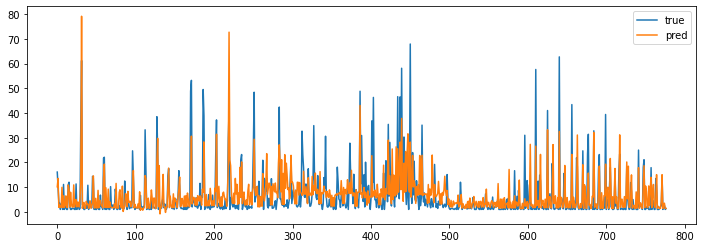

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(test_Y_1, label='true')
plt.plot(pred_Y_1, label='pred')
plt.legend(loc = 'best')
plt.show()

In [ ]:
pd.DataFrame({
    'col' : train_X_0.columns, 'feature importance' : lgb_model.feature_importances_
}).sort_values('feature importance', ascending=False)

col  feature importance
4         cnt                1203
6      max_pa                 319
1        PM25                 227
2      avg_ta                 195
0        PM10                 178
8      min_ta                 178
3      avg_ws                 175
11  sum_ss_hr                 149
7      max_ta                 140
5      hm_max                 126
9      rn_day                  61
10     rn_hr1                  49

In [ ]:
lgb_model.fit(train_X_2, train_Y_2)
pred_Y_2 = lgb_model.predict(test_X_2)
print(mean_squared_error(test_Y_2, pred_Y_2))

10.928982140688074


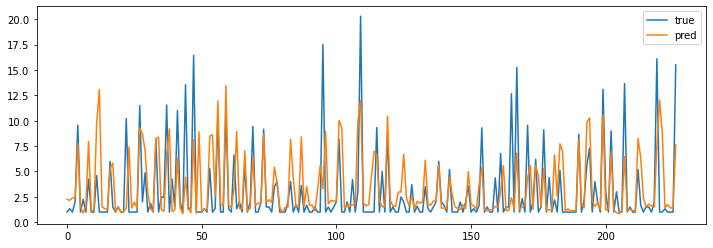

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(test_Y_2, label='true')
plt.plot(pred_Y_2, label='pred')
plt.legend(loc = 'best')
plt.show()

In [ ]:
pd.DataFrame({
    'col' : train_X_0.columns, 'feature importance' : lgb_model.feature_importances_
}).sort_values('feature importance', ascending=False)

col  feature importance
4         cnt                1052
6      max_pa                 306
5      hm_max                 253
11  sum_ss_hr                 207
1        PM25                 194
3      avg_ws                 191
0        PM10                 190
8      min_ta                 180
7      max_ta                 133
2      avg_ta                 120
9      rn_day                  95
10     rn_hr1                  79

### 2-4. Gradient Boosting

In [ ]:
gb_model = GradientBoostingRegressor() 
gb_model.fit(train_X_0, train_Y_0)
pred_Y_0 = gb_model.predict(test_X_0)
print(mean_squared_error(test_Y_0, pred_Y_0))

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


50.019378658919


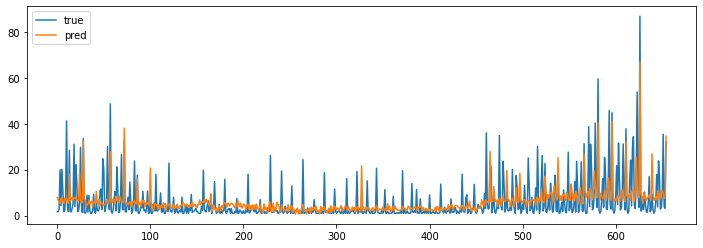

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(test_Y_0, label='true')
plt.plot(pred_Y_0, label='pred')
plt.legend(loc = 'best')
plt.show()

In [ ]:
pd.DataFrame({
    'col' : train_X_0.columns, 'feature importance' : gb_model.feature_importances_
}).sort_values('feature importance', ascending=False)

col  feature importance
4         cnt            0.605788
7      max_ta            0.096974
2      avg_ta            0.091965
6      max_pa            0.087251
1        PM25            0.050417
0        PM10            0.021162
8      min_ta            0.020897
5      hm_max            0.009601
3      avg_ws            0.008327
11  sum_ss_hr            0.006725
10     rn_hr1            0.000606
9      rn_day            0.000288

In [ ]:
gb_model.fit(train_X_1, train_Y_1)
pred_Y_1 = gb_model.predict(test_X_1)
print(mean_squared_error(test_Y_1, pred_Y_1))

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


52.12975711836524


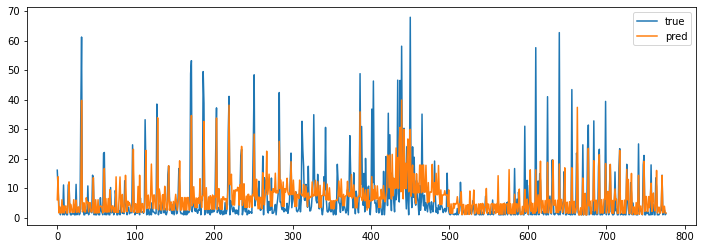

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(test_Y_1, label='true')
plt.plot(pred_Y_1, label='pred')
plt.legend(loc = 'best')
plt.show()

In [ ]:
pd.DataFrame({
    'col' : train_X_0.columns, 'feature importance' : gb_model.feature_importances_
}).sort_values('feature importance', ascending=False)

col  feature importance
4         cnt            0.858109
8      min_ta            0.029742
6      max_pa            0.019767
2      avg_ta            0.018488
5      hm_max            0.017609
1        PM25            0.016354
7      max_ta            0.013837
0        PM10            0.010688
11  sum_ss_hr            0.008435
3      avg_ws            0.005248
9      rn_day            0.000983
10     rn_hr1            0.000741

In [ ]:
gb_model.fit(train_X_2, train_Y_2)
pred_Y_2 = gb_model.predict(test_X_2)
print(mean_squared_error(test_Y_2, pred_Y_2))

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


10.44743974729529


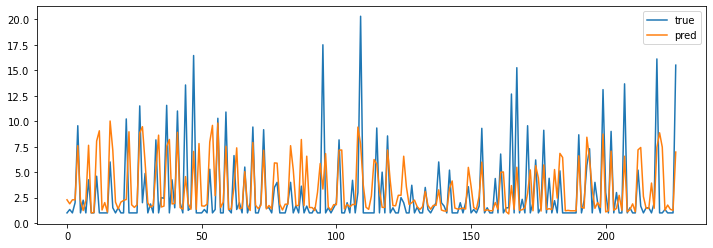

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(test_Y_2, label='true')
plt.plot(pred_Y_2, label='pred')
plt.legend(loc = 'best')
plt.show()

In [ ]:
pd.DataFrame({
    'col' : train_X_0.columns, 'feature importance' : gb_model.feature_importances_
}).sort_values('feature importance', ascending=False)

col  feature importance
4         cnt            0.807676
6      max_pa            0.041447
8      min_ta            0.030979
1        PM25            0.030741
0        PM10            0.030424
5      hm_max            0.017676
2      avg_ta            0.015383
7      max_ta            0.008825
11  sum_ss_hr            0.006342
3      avg_ws            0.005347
10     rn_hr1            0.002912
9      rn_day            0.002247